In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from numba import njit
from heston_lsm_utils import simulate_heston_paths, simulate_bs_paths, least_squares_monte_carlo, heston_simulations, bs_simulations
import seaborn as sns
sns.set(
    style="whitegrid",
    palette="muted",
    font_scale=1.2
)

In [7]:

# Simulation of paths 

def generate_correlated_BMs(N, M, rho):
    Z1 = np.random.randn(N, M)
    if rho == 0:
        Z2 = np.zeros((N, M))
    else:
        Z2_raw = np.random.randn(N, M)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2_raw
    return Z1, Z2

def simulate_heston_paths(S0, v0, kappa, theta, sigma, r, rho, T, M, N):
    dt = T / M
    S = np.zeros((N, M+1))
    v = np.zeros((N, M+1))
    S[:,0], v[:,0] = S0, v0
    W1, W2 = generate_correlated_BMs(N, M, rho)
    for t in range(1, M+1):
        v[:,t] = np.maximum(
            v[:,t-1] + kappa*(theta-v[:,t-1])*dt
            + sigma*np.sqrt(v[:,t-1]*dt)*W2[:,t-1],
            0
        )
        S[:,t] = S[:,t-1] * np.exp(
            (r - 0.5*v[:,t-1]) * dt
            + np.sqrt(v[:,t-1]*dt)*W1[:,t-1]
        )
    return S, v

def simulate_bs_paths(S0, sigma, r, T, M, N):
    dt = T / M
    S = np.zeros((N, M+1))
    S[:,0] = S0
    for t in range(1, M+1):
        Z = np.random.randn(N)
        S[:,t] = S[:,t-1] * np.exp(
            (r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z
        )
    return S

# LSM Solver

def laguerre_basis(x):
    return np.column_stack([np.ones_like(x), 1-x, 1-2*x+0.5*x**2])

def least_squares_monte_carlo(
    S, v, K, r, T, M,
    track_boundary: bool = False,
    track_timing:  bool = False
):
    dt = T / M
    N  = S.shape[0]
    
    # intrinsic payoffs and storage
    intrinsic = np.maximum(K - S, 0)
    cashflows = intrinsic[:, -1].copy()
    exercised = np.zeros(N, dtype=bool)
    
    # prepare optional outputs
    boundary = np.full(M+1, np.nan) if track_boundary else None
    times    = np.full(N,     np.nan) if track_timing  else None

    # backward induction
    for t in range(M-1, 0, -1):
        itm = intrinsic[:, t] > 0
        if not itm.any():
            continue

        # regression basis [L0, L1, L2, v, v^2]
        x_norm = (S[itm, t] / K).reshape(-1, 1)
        L      = laguerre_basis(x_norm.flatten())
        vcol   = v[itm, t].reshape(-1, 1)
        X      = np.hstack([L, vcol, vcol**2])

        # discounted continuation values
        Y    = cashflows[itm] * np.exp(-r * dt)
        cont = LinearRegression().fit(X, Y).predict(X)

        # exercise decision
        ex   = intrinsic[itm, t] > cont
        idxs = np.where(itm)[0]

        # track first exercise time
        if track_timing:
            for idx, did in zip(idxs, ex):
                if did and np.isnan(times[idx]):
                    times[idx] = t * dt

        # update exercised mask & cashflows
        exercised[itm] |= ex
        cashflows[itm] = np.where(
            ex,
            intrinsic[itm, t],
            cashflows[itm] * np.exp(-r * dt)
        )

        # track a high quantile of exercised prices, if requested
        if track_boundary and ex.any():
            prices_ex = S[itm, t][ex]
            boundary[t] = np.percentile(prices_ex, 95)

    # final price and exercise frequency
    price = np.exp(-r * dt) * cashflows.mean()
    freq  = exercised.mean()

    # return according to flags
    if track_boundary and track_timing:
        return price, freq, boundary, times
    if track_boundary:
        return price, freq, boundary
    if track_timing:
        return price, freq, times
    return price, freq

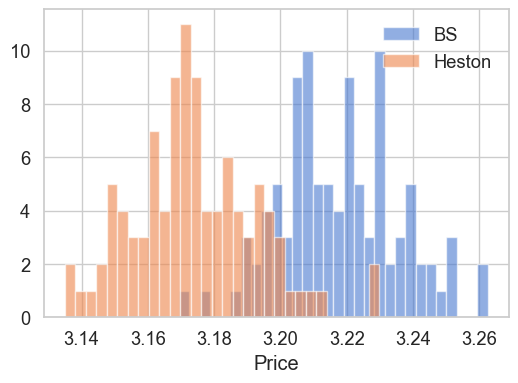

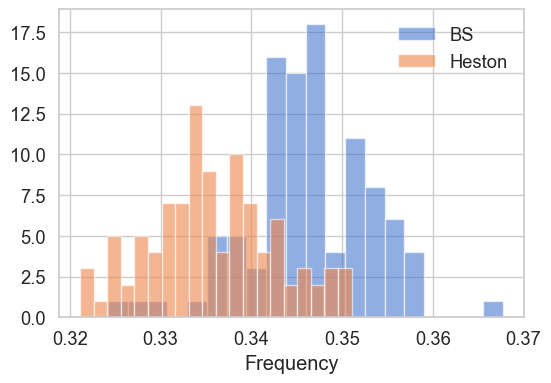

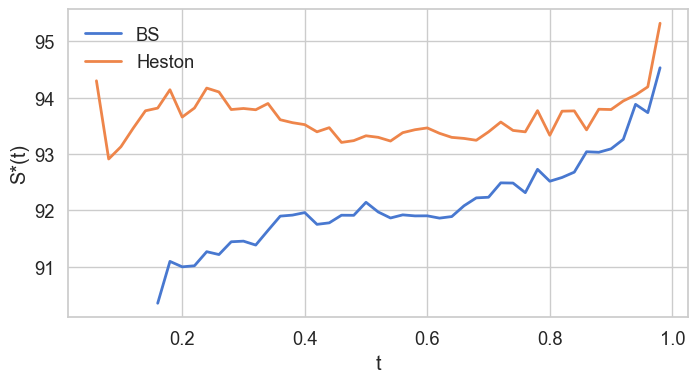

/var/folders/dm/v2ztg7hn3_z54xvh868kqz300000gn/T/ipykernel_63369/2310141350.py:112: RuntimeWarning: Mean of empty slice
  ax.plot(time_grid, np.nanmean(b_all,axis=0), label=f"{param}={val}")
/var/folders/dm/v2ztg7hn3_z54xvh868kqz300000gn/T/ipykernel_63369/2310141350.py:112: RuntimeWarning: Mean of empty slice
  ax.plot(time_grid, np.nanmean(b_all,axis=0), label=f"{param}={val}")
/var/folders/dm/v2ztg7hn3_z54xvh868kqz300000gn/T/ipykernel_63369/2310141350.py:112: RuntimeWarning: Mean of empty slice
  ax.plot(time_grid, np.nanmean(b_all,axis=0), label=f"{param}={val}")
/var/folders/dm/v2ztg7hn3_z54xvh868kqz300000gn/T/ipykernel_63369/2310141350.py:112: RuntimeWarning: Mean of empty slice
  ax.plot(time_grid, np.nanmean(b_all,axis=0), label=f"{param}={val}")
/var/folders/dm/v2ztg7hn3_z54xvh868kqz300000gn/T/ipykernel_63369/2310141350.py:112: RuntimeWarning: Mean of empty slice
  ax.plot(time_grid, np.nanmean(b_all,axis=0), label=f"{param}={val}")
/var/folders/dm/v2ztg7hn3_z54xvh868kqz300000g

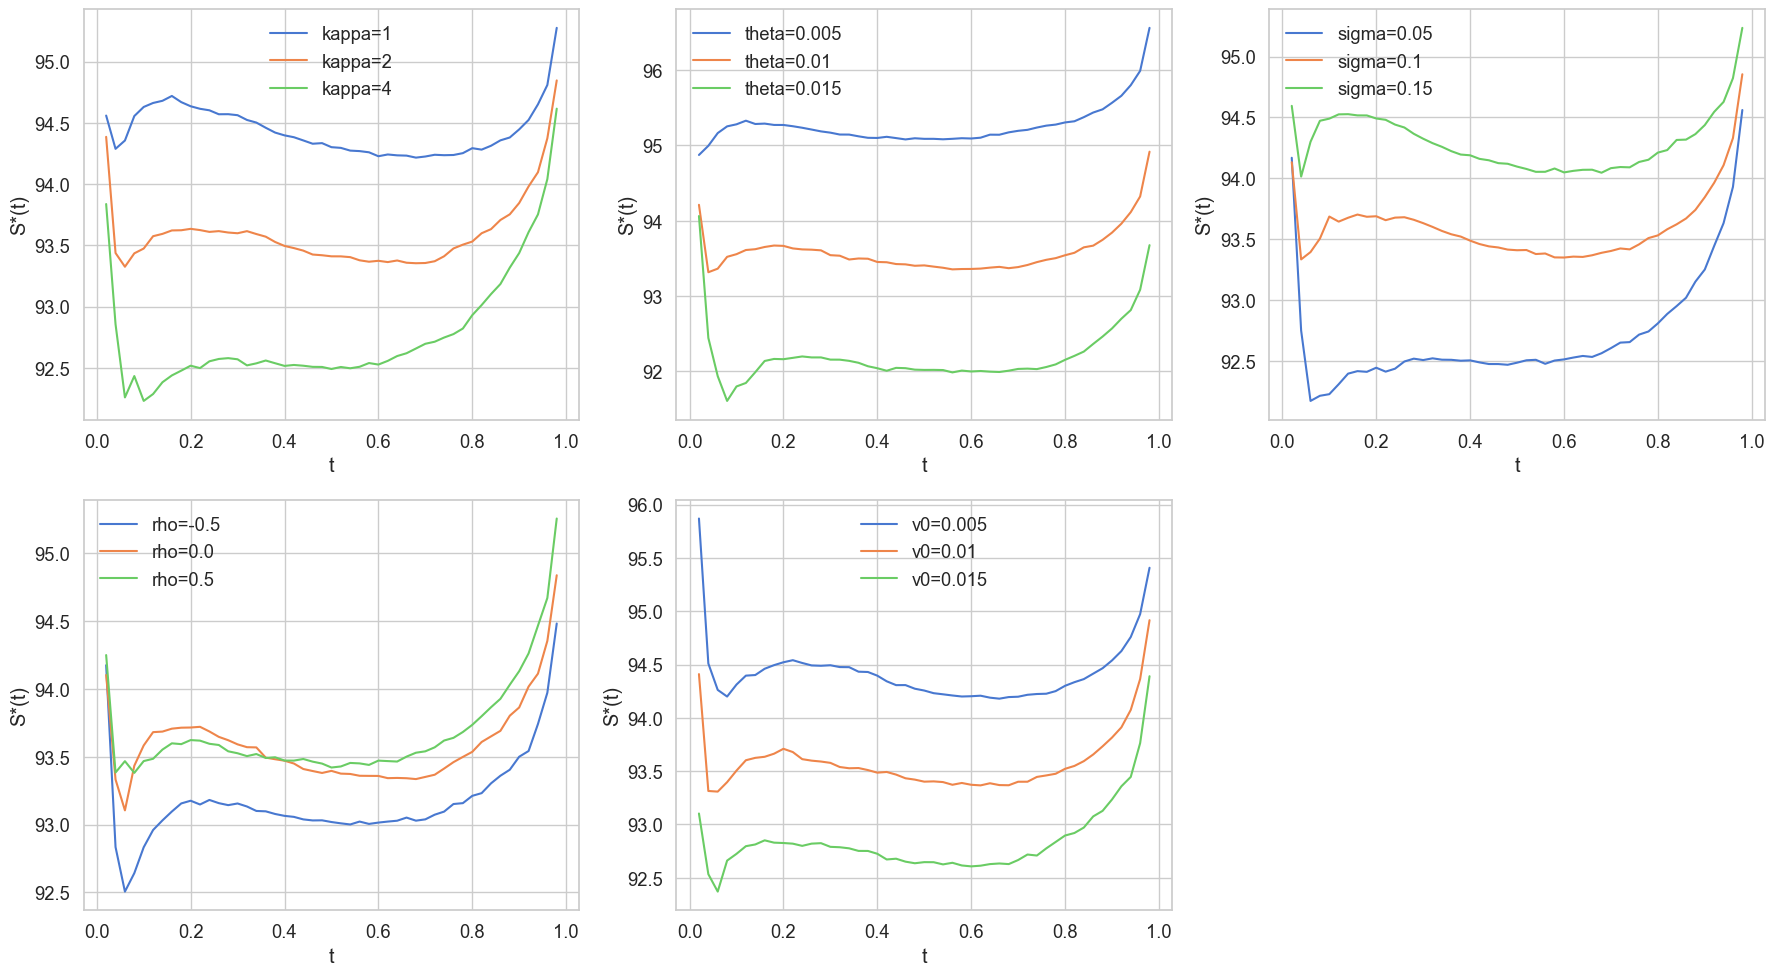

/var/folders/dm/v2ztg7hn3_z54xvh868kqz300000gn/T/ipykernel_63369/2310141350.py:135: RuntimeWarning: Mean of empty slice
  h_mean = np.nanmean(h_b,axis=0);   h_lo = np.nanpercentile(h_b,5,axis=0);   h_hi = np.nanpercentile(h_b,95,axis=0)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/var/folders/dm/v2ztg7hn3_z54xvh868kqz300000gn/T/ipykernel_63369/2310141350.py:136: RuntimeWarning: Mean of empty slice
  bs_mean= np.nanmean(bs_b2,axis=0); bs_lo= np.nanpercentile(bs_b2,5,axis=0); bs_hi= np.nanpercentile(bs_b2,95,axis=0)


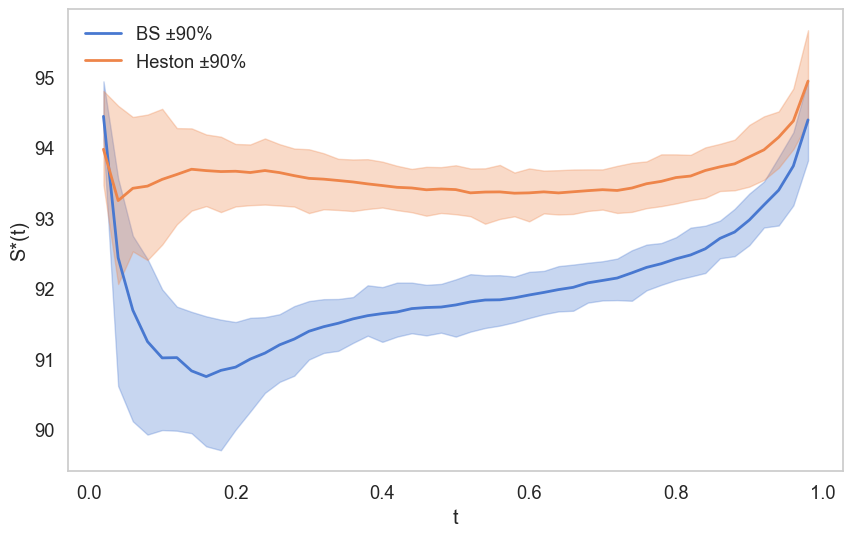

/var/folders/dm/v2ztg7hn3_z54xvh868kqz300000gn/T/ipykernel_63369/2310141350.py:147: RuntimeWarning: divide by zero encountered in scalar divide
  S_inf = (beta/(beta-1))*K


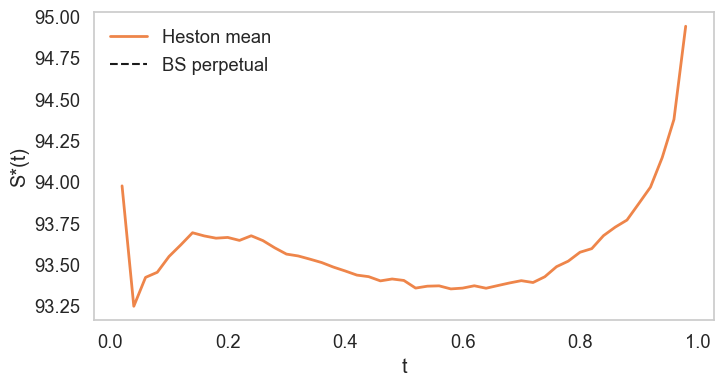

In [ ]:
# PARAMETERS
S0, K, T, r = 100, 100, 1.0, 0.02
kappa, theta, sigma, rho, v0 = 2.0, 0.01, 0.1, 0, 0.01
M, N = 50, 50000
num_hist, num_sweep, R = 100, 100, 100
np.random.seed(0)

time_grid = np.linspace(0, T, M+1)
kappa_vals = [1, 2, 4]
theta_vals = [0.005, 0.01, 0.015]
sigma_vals = [0.05, 0.1, 0.15]
rho_vals   = [-0.5, 0.0, 0.5]
v0_vals    = [0.005, 0.01, 0.015]

# 1) Price & Frequency Distributions 
bs_prices, bs_freqs = [], []
for _ in range(num_hist):
    S_b = simulate_bs_paths(S0, sigma, r, T, M, N)
    price, freq = least_squares_monte_carlo(
        S=S_b,
        v=np.full_like(S_b, sigma**2),
        K=K,
        r=r,
        T=T,
        M=M
    )
    bs_prices.append(price)
    bs_freqs.append(freq)

h_prices, h_freqs = [], []
for _ in range(num_hist):
    S_h, v_h = simulate_heston_paths(S0, v0, kappa, theta, sigma, r, rho, T, M, N)
    price, freq = least_squares_monte_carlo(
        S=S_h,
        v=v_h,
        K=K,
        r=r,
        T=T,
        M=M
    )
    h_prices.append(price)
    h_freqs.append(freq)

plt.figure(figsize=(6,4))
plt.hist(bs_prices, bins=30, alpha=0.6, label="BS")
plt.hist(h_prices,  bins=30, alpha=0.6, label="Heston")
# plt.title("Price Distribution")
plt.xlabel("Price")
plt.legend(frameon=False)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(bs_freqs, bins=20, alpha=0.6, label="BS")
plt.hist(h_freqs,  bins=20, alpha=0.6, label="Heston")
# plt.title("Early‐Exercise Frequency")
plt.xlabel("Frequency")
plt.legend(frameon=False)
plt.show()

# 2) Baseline Early‐Exercise Boundary Overlay
S_bs = simulate_bs_paths(S0, sigma, r, T, M, N)
v_bs = np.full((N, M+1), sigma**2)
bs_price, bs_freq, bs_b = least_squares_monte_carlo(
    S=S_bs, v=v_bs, K=K, r=r, T=T, M=M, track_boundary=True
)

S_he, v_he = simulate_heston_paths(S0, v0, kappa, theta, sigma, r, rho, T, M, N)
he_price, he_freq, he_b = least_squares_monte_carlo(
    S=S_he, v=v_he, K=K, r=r, T=T, M=M, track_boundary=True
)

plt.figure(figsize=(8,4))
plt.plot(time_grid, bs_b, label="BS", lw=2)
plt.plot(time_grid, he_b, label="Heston", lw=2)
# plt.title("Baseline Early‐Exercise Boundary")
plt.xlabel("t"); plt.ylabel("S*(t)")
plt.legend(frameon=False)
plt.grid(True)
plt.show()

# 3) Parameter Sweeps (2×3 grid)
fig, axes = plt.subplots(2,3,figsize=(18,10))
axes = axes.flatten()
param_dict = {
    'kappa': kappa_vals,
    'theta': theta_vals,
    'sigma': sigma_vals,
    'rho':   rho_vals,
    'v0':    v0_vals
}

for ax, (param, vals) in zip(axes, param_dict.items()):
    for val in vals:
        sim = dict(S0=S0, v0=v0, kappa=kappa, theta=theta,
                   sigma=sigma, r=r, rho=rho,
                   T=T, M=M, N=N, K=K)
        sim[param] = val

        b_all = []
        for _ in range(num_sweep):
            S_p, v_p = simulate_heston_paths(
                sim['S0'], sim['v0'], sim['kappa'], sim['theta'],
                sim['sigma'], sim['r'], sim['rho'],
                sim['T'], sim['M'], sim['N']
            )
            _, _, b = least_squares_monte_carlo(
                S=S_p, v=v_p,
                K=K, r=r, T=T, M=M,
                track_boundary=True
            )
            b_all.append(b)
        ax.plot(time_grid, np.nanmean(b_all,axis=0), label=f"{param}={val}")

    ax.set(xlabel="t", ylabel="S*(t)")
    ax.legend(frameon=False)
    ax.grid(True)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# 4) Mean ± 90% Confidence Bands & Perpetual‐Put Overlay
h_b = np.zeros((R,M+1)); bs_b2 = np.zeros((R,M+1))
for i in range(R):
    S_h, v_h = simulate_heston_paths(S0, v0, kappa, theta, sigma, r, rho, T, M, N)
    _, _, h_b[i] = least_squares_monte_carlo(
        S=S_h, v=v_h, K=K, r=r, T=T, M=M, track_boundary=True
    )
    S_b        = simulate_bs_paths(S0, sigma, r, T, M, N)
    v_b        = np.full((N,M+1), sigma**2)
    _, _, bs_b2[i] = least_squares_monte_carlo(
        S=S_b, v=v_b, K=K, r=r, T=T, M=M, track_boundary=True
    )

h_mean = np.nanmean(h_b,axis=0);   h_lo = np.nanpercentile(h_b,5,axis=0);   h_hi = np.nanpercentile(h_b,95,axis=0)
bs_mean= np.nanmean(bs_b2,axis=0); bs_lo= np.nanpercentile(bs_b2,5,axis=0); bs_hi= np.nanpercentile(bs_b2,95,axis=0)

plt.figure(figsize=(10,6))
plt.fill_between(time_grid, bs_lo, bs_hi, color="C0", alpha=0.3)
plt.plot(time_grid, bs_mean, color="C0", lw=2, label="BS ±90%")
plt.fill_between(time_grid, h_lo , h_hi , color="C1", alpha=0.3)
plt.plot(time_grid, h_mean, color="C1", lw=2, label="Heston ±90%")
plt.xlabel("t"); plt.ylabel("S*(t)")
plt.legend(frameon=False); plt.grid(); plt.show()

beta  = (0.5 - r/sigma**2) + np.sqrt((r/sigma**2-0.5)**2 + 2*r/sigma**2)
S_inf = (beta/(beta-1))*K

plt.figure(figsize=(8,4))
plt.plot(time_grid, h_mean, color="C1", lw=2, label="Heston mean")
plt.hlines(S_inf,0,T,colors="k",linestyles="--",label="BS perpetual")
plt.xlabel("t"); plt.ylabel("S*(t)")
plt.legend(frameon=False); plt.grid(); plt.show()


In [ ]:

# Scenario grid for each Heston parameter (low, baseline, high)
param_levels = {
    'kappa': [1, 2, 4],
    'theta': [0.005, 0.01, 0.02],
    'sigma': [0.05, 0.1, 0.2],
    'rho':   [-0.5, 0.0, 0.5],
    'v0':    [0.005, 0.01, 0.02]
}

# Fixed baseline values
fixed = {
    'S0': S0, 'K': K, 'T': T, 'r': r,
    'kappa': kappa, 'theta': theta,
    'sigma': sigma, 'rho': rho, 'v0': v0,
    'M': M, 'N': N
}

# Number of Monte Carlo trials per scenario
num_runs = 100
np.random.seed(0)
# Collect results 
results = []
for param, levels in param_levels.items():
    for level in levels:
        sim = fixed.copy()
        sim[param] = level
        
        prices, freqs, avg_times = [], [], []
        for _ in range(num_runs):
            # 1) simulate a batch of paths
            S_paths, v_paths = simulate_heston_paths(
                sim['S0'], sim['v0'],
                sim['kappa'], sim['theta'], sim['sigma'],
                sim['r'], sim['rho'],
                sim['T'], sim['M'], sim['N']
            )
            # 2) run LSM, get (price, freq, times)
            price, freq, times = least_squares_monte_carlo(
                S=S_paths,
                v=v_paths,
                K=sim['K'],
                r=sim['r'],
                T=sim['T'],
                M=sim['M'],
                track_timing=True
            )
            prices.append(price)
            freqs.append(freq)
            # normalize the average exercise time to [0,1]
            avg_times.append(np.nanmean(times) / sim['T'])
        
        # aggregate metrics for this scenario
        results.append({
            'Parameter':       param,
            'Level':           level,
            'Option Value':    np.mean(prices),
            'Early-Ex. Freq.': np.mean(freqs),
            'Avg. Ex. Time':   np.mean(avg_times)
        })

# Build DataFrame and display
df = pd.DataFrame(results)
df = df[['Parameter','Level','Option Value','Early-Ex. Freq.','Avg. Ex. Time']]
display(df)


,Parameter,Level,Option Value,Early-Ex. Freq.,Avg. Ex. Time
0,kappa,1.000,3.143191,0.331766,0.873494
1,kappa,2.000,3.173700,0.335480,0.882810
2,kappa,4.000,3.203783,0.340423,0.890180
3,theta,0.005,2.615472,0.351090,0.862486
4,theta,0.010,3.173392,0.335459,0.882866
5,theta,0.020,4.126743,0.327225,0.906933
6,sigma,0.050,3.211026,0.343983,0.890616
7,sigma,0.100,3.176452,0.336112,0.883283
8,sigma,0.200,3.069659,0.315152,0.867215
9,rho,-0.500,3.210378,0.307455,0.878101


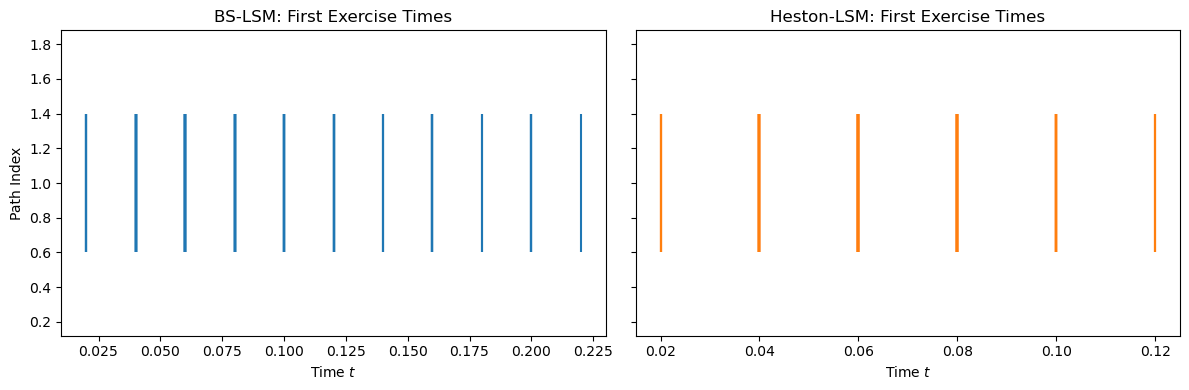

In [4]:
# Number of individual paths to display
num_paths_plot = 100

# Arrays to hold first‐exercise times
bs_times = np.zeros(num_paths_plot)
h_times  = np.zeros(num_paths_plot)

# Loop over paths
for i in range(num_paths_plot):
    # --- Black–Scholes path and exercise time ---
    S_b = simulate_bs_paths(S0, sigma, r, T, M, N)
    _, _, times_b = least_squares_monte_carlo(
        S=S_b,
        v=np.full_like(S_b, sigma**2),
        K=K,
        r=r,
        T=T,
        M=M,
        track_timing=True
    )
    bs_times[i] = np.nanmin(times_b)  # first non‐NaN entry

    # --- Heston path and exercise time ---
    S_h, v_h = simulate_heston_paths(S0, v0, kappa, theta, sigma, r, rho, T, M, N)
    _, _, times_h = least_squares_monte_carlo(
        S=S_h,
        v=v_h,
        K=K,
        r=r,
        T=T,
        M=M,
        track_timing=True
    )
    h_times[i] = np.nanmin(times_h)

# Now plot them side by side
fig, (ax_bs, ax_h) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax_bs.eventplot(bs_times, orientation='horizontal', colors='C0', linelengths=0.8)
ax_bs.set_title("BS‐LSM: First Exercise Times")
ax_bs.set_xlabel("Time $t$")
ax_bs.set_ylabel("Path Index")

ax_h.eventplot(h_times, orientation='horizontal', colors='C1', linelengths=0.8)
ax_h.set_title("Heston‐LSM: First Exercise Times")
ax_h.set_xlabel("Time $t$")

plt.tight_layout()
plt.show()
